In [8]:
import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

from model import build_unet
from utils import create_dir, seeding

import matplotlib.pyplot as plt

In [9]:
def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = build_unet()
model = model.to(device)
model.load_state_dict(torch.load('./toy.pth', map_location=device))
model.eval()

build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [55]:
image = cv2.resize(cv2.imread('../data/uncleaned/test/img/ARIA_aria_d_17_2.jpg', cv2.IMREAD_COLOR), (512,512)) ## (512, 512, 3)
x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
x = x/255.0
x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
x = x.astype(np.float32)
x = torch.from_numpy(x)
x = x.to(device)

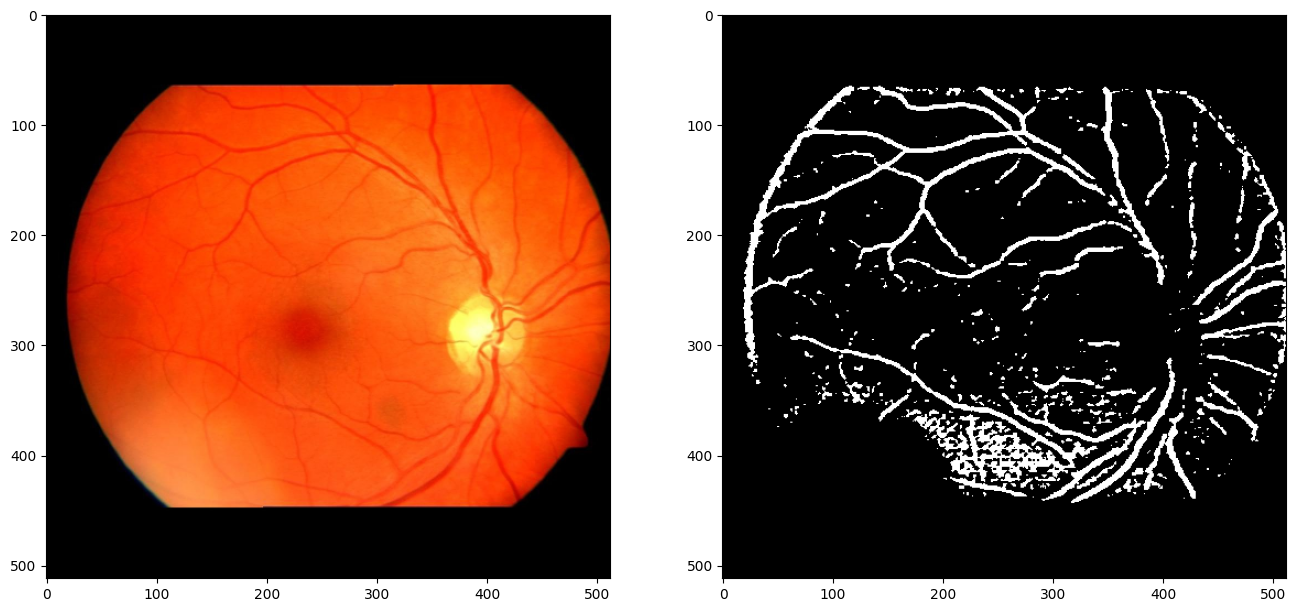

In [56]:
with torch.no_grad():
    pred_y = model(x)
    pred_y = torch.sigmoid(pred_y)

    pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
    pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
    pred_y = pred_y > 0.5
    pred_y = np.array(pred_y, dtype=np.uint8)

    pred_y = mask_parse(pred_y)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,9)
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[1].imshow(pred_y * 255)

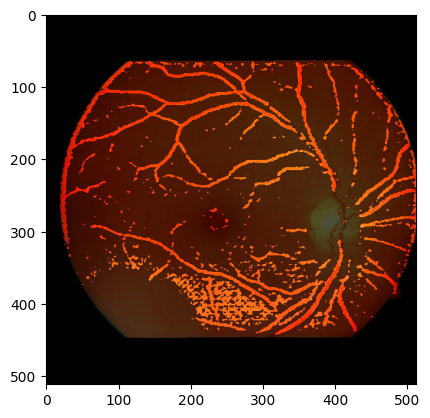

In [57]:
pred_inv = (pred_y)
plt.imshow(cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),0.3,cv2.cvtColor(image*pred_inv, cv2.COLOR_BGR2RGB),1,1))

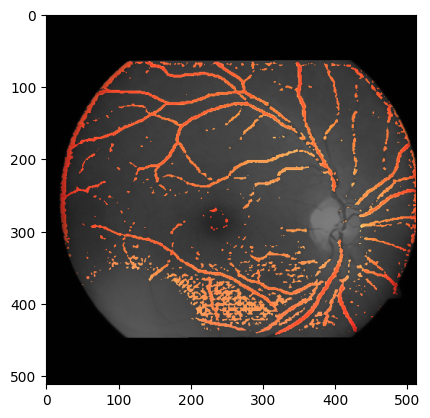

In [58]:
pred_inv = (pred_y)
plt.imshow(cv2.addWeighted(cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cv2.COLOR_BGR2RGB),0.5,cv2.cvtColor(image*pred_inv, cv2.COLOR_BGR2RGB),1,1))